# 필요 라이브러리 가져오기

In [60]:
import collections
from functools import partial

import torch

import evaluate
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from transformers import pipeline, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM

from transformers import BitsAndBytesConfig, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

from transformers import TrainerCallback
import matplotlib.pyplot as plt

import json

import huggingface_hub
huggingface_hub.login('##허깅페이스 토큰ID##')

# 모델, 데이터셋 이름 설정

In [61]:
model_name = "meta-llama/Llama-3.2-1B" # Decoder-only 구조의 오픈소스 LLM

dataset_name = "KorQuAD/squad_kor_v1"

# 데이터셋 로드 및 전처리(+토크나이징)

In [68]:
data = load_dataset(dataset_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, padding_side='left') # pretrained 모델이 사용한 토크나이저를 사용
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # pad_token 직접 추가

1

In [69]:
print(data) # 데이터 구조 확인을 위함

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})


In [7]:
def preprocess_function(examples): # 데이터 전처리를 위한 함수
    inputs = [] # context와 
    outputs = []
    
    for question, context, answer_dict in zip(examples["question"], examples["context"], examples["answers"]):
        answer = answer_dict["text"][0]
        
        input_text = f"질문: {question} \n맥락: {context} \n답변" + " " + tokenizer.eos_token # 모델에 입력할 프롬프트
        
        output_text = f" {answer}" + " " + tokenizer.eos_token # 라벨값

        inputs.append(input_text)
        outputs.append(output_text)

    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding='max_length', add_special_tokens=True)

    # 정답(출력) 토크나이징 및 패딩
    labels = tokenizer(outputs, max_length=512, truncation=True, padding='max_length', add_special_tokens=True)["input_ids"]

    # 정답값들의 패딩 설정
    model_inputs["labels"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in seq]
        for seq in labels
    ]

    return model_inputs

In [8]:
tokenized_datasets = data.map(preprocess_function, batched=True, remove_columns=["id", "title", "context", "question", "answers"]) # 기존 col을 지우고 입력, 정답값만 남김

In [9]:
for i in range(5): # 토크나이징된 데이터 확인
    labels = tokenized_datasets["validation"][i]["labels"]
    decoded_labels = tokenizer.decode([token for token in labels if token != -100])
    print(f"Sample {i+1} Labels:\n{decoded_labels}\n")

Sample 1 Labels:
<|begin_of_text|> 1989년 2월 15일 <|end_of_text|>

Sample 2 Labels:
<|begin_of_text|> 임수경 <|end_of_text|>

Sample 3 Labels:
<|begin_of_text|> 1989년 <|end_of_text|>

Sample 4 Labels:
<|begin_of_text|> 학생회관 건물 계단 <|end_of_text|>

Sample 5 Labels:
<|begin_of_text|> 서울지방경찰청 공안분실 <|end_of_text|>



# 모델 로드 및 전처리(+양자화)

In [10]:
quantization_config = BitsAndBytesConfig( # 양자화 적용
    load_in_4bit=True,  # 4-bit 양자화 적용
    bnb_4bit_compute_dtype=torch.float16,  # 연산은 FP16으로 수행
    bnb_4bit_use_double_quant=True,  # double quantization을 통해 추가적인 양자화 적용(4bit로 변환한 가중치를 8bit로 다시 양자화하여 메모리 사용 최적화)
)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained( # pretrained된 모델을 가져오는 함수
    model_name,
    quantization_config=quantization_config, # 양자화를 적용하여 모델을 가져옴
    torch_dtype=torch.bfloat16,
    device_map="auto",
    offload_folder="./offload"
)
model.config.use_cache = False
model.resize_token_embeddings(len(tokenizer)) # pad_token추가로 토큰 사이즈 변경

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128257, 2048)

In [12]:
lora_config = LoraConfig( # LoRA적용(추가적인 작은 가중치만 학습해 메모리를 절약함)
    r=8,  # LoRA 랭크 크기
    lora_alpha=32,  # LoRA scaling factor
    lora_dropout=0.1,  # LoRA dropout(과적합 방지)
    target_modules=["q_proj", "v_proj"],  # LoRA 적용 부분
)

model = prepare_model_for_kbit_training(model) # 4-bit 모델 학습 준비, 무조건 get_peft_model보다 앞에 있어야 함, 아니면 학습 가능 파라미터 0이 됨
model = get_peft_model(model, lora_config) #모델에 적용

In [13]:
model.print_trainable_parameters() # 학습하는 파라미터 표시(LoRA로 인해 6.89%의 가중치만 학습하게 됨)

trainable params: 851,968 || all params: 1,236,668,416 || trainable%: 0.0689


# Trainer 매개변수 설정

In [40]:
training_args = TrainingArguments(
    output_dir="./results", # 학습 관련 정보 저장 디렉토리 설정
    evaluation_strategy="steps", # 설정한 step에 따라 evaluation수행
    save_strategy="steps", # 설정한 step에 따라 로그 저장
    num_train_epochs=2, # epoch 설정
    per_device_train_batch_size=8, # train, eval 배치사이즈 설정
    per_device_eval_batch_size=8,
    learning_rate=2e-4, # learning rate 설정
    label_names=["labels"], # 라벨값은 이곳에 있다고 설정
    
    logging_dir="./logs", # 학습 로그 저장 디렉토리 설정
    save_steps=200, # 200배치마다 학습 로그 저장
    eval_steps=200, # 200배치마다 evaluation 로그 기록
    logging_steps=200, # 200배치마다 로그 기록
    logging_first_step=True, # 첫 번째 배치를 학습하고 로그 기록
    report_to="none", # 학습 로그를 실시간 확인할 수 있는 코드. tensorboard, wandb등을 넣을 수 있다.

    fp16=False, # FP16 학습 비활성화
    bf16=True, # BF16 학습 활성화 (RTX 3060, A100과 같은 고성능 GPU에서 더욱 빠른 학습을 가능하게 하는 연산, A5000에서도 가능하다고 판단)
    optim="adamw_torch",  # FP16, BF16 학습에 최적화된 최적화함수 AdamW 사용
    gradient_accumulation_steps=4, # 여러 배치의 그래디언트를 누적하여 학습하여, 메모리 최적화
    gradient_checkpointing=True, # 모든 중간 활성화값을 저장하지 않고 역전파 시 다시 계산하여 메모리 최적화
    remove_unused_columns=False, # trainer에서 label을 없앤다고 판단하여 col을 지우지 못하도록 설정
)

/usr/gatoai/python/venv/3.10/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
trainer = Trainer(
    model=model, # 위에서 정의한 양자화된 모델 사용
    args=training_args, # 위에서 정의한 training 매개변수들 사용
    train_dataset=tokenized_datasets["train"], # train시, 이 데이터셋 사용
    eval_dataset=tokenized_datasets["validation"], # validation시, 이 데이터셋 사용
    tokenizer=tokenizer, # 위에서 설정한 토크나이저 사용
)

/tmp/ipykernel_8370/3047345714.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# 학습 진행

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
200,2.210400,2.194320
400,2.133400,1.988653
600,1.995800,1.908449
800,1.946400,1.832593
1000,1.901300,1.787891
1200,1.838800,1.762307
1400,1.796400,1.724072
1600,1.761600,1.717009
1800,1.768100,1.692554
2000,1.684600,1.676257


/usr/gatoai/python/venv/pytorch-2.6.0-cuda12.4-py3.10/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/gatoai/python/venv/pytorch-2.6.0-cuda12.4-py3.10/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/gatoai/python/venv/pytorch-2.6.0-cuda12.4-py3.10/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/gatoai/python/venv/pytorch-2.6.0-cuda12.4-py3.10/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/gatoai/

# 학습 결과 시각화

In [66]:
with open("results/checkpoint-3774/trainer_state.json", "r") as f: # JSON 파일 로드
    data = json.load(f)

log_history = data["log_history"]

eval_loss_list = []
train_loss_list = []

# log_history 순회 (디렉토리 이름이 0부터 36까지라고 가정)
for dir_name, log in enumerate(log_history): # log_history를 돌며 디렉토리 이름이 짝수면 안에서 eval_loss값을 eval_loss_list에 넣고 홀수면 안에서 loss값을 찾아 train_loss_list를 찾아 넣는 반복문
    if dir_name % 2 == 0 and "eval_loss" in log:
        eval_loss_list.append(log["eval_loss"])
    elif dir_name % 2 == 1 and "loss" in log:
        train_loss_list.append(log["loss"])

steps = [200 * i for i in range(1, 19)]

print("Eval Loss List:", eval_loss_list)
print("Train Loss List:", train_loss_list)


Eval Loss List: [2.1943199634552, 1.9886531829833984, 1.9084490537643433, 1.8325930833816528, 1.7878907918930054, 1.7623072862625122, 1.724071741104126, 1.717009425163269, 1.692553997039795, 1.6762566566467285, 1.6637895107269287, 1.6569867134094238, 1.6365770101547241, 1.6232883930206299, 1.6188353300094604, 1.611746907234192, 1.6078730821609497, 1.598980188369751]
Train Loss List: [2.2104, 2.1334, 1.9958, 1.9464, 1.9013, 1.8388, 1.7964, 1.7616, 1.7681, 1.6846, 1.6134, 1.6014, 1.6266, 1.5852, 1.5803, 1.5675, 1.5616, 1.5666]


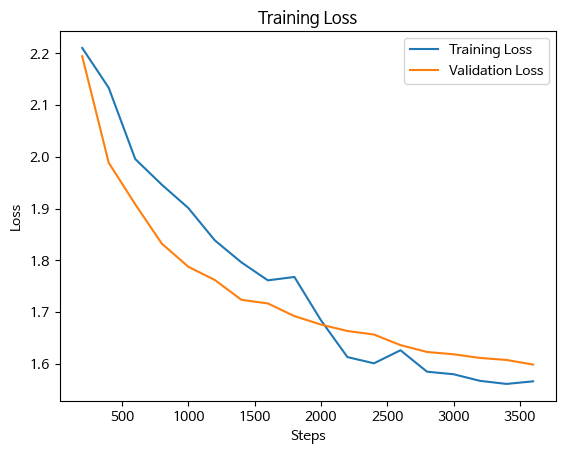

In [67]:
plt.plot(steps, train_loss_list, label="Training Loss")
plt.plot(steps, eval_loss_list, label="Validation Loss")
plt.xlabel("Steps") 
plt.ylabel("Loss") 
plt.legend()
plt.title("Training Loss")
plt.show()

# 보고서

## 1. KorQuAD/squad_kor_v1 데이터셋

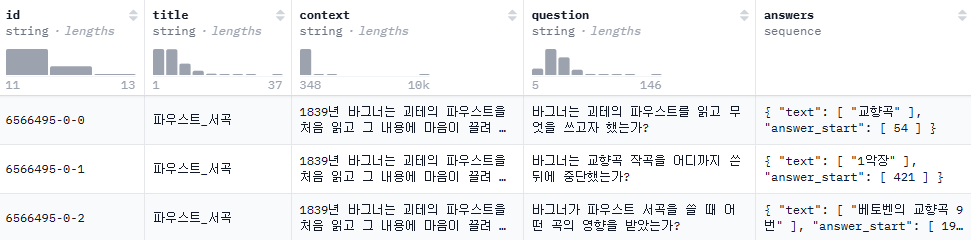

SQuAD형식으로 이루어진 데이터셋이며 Question Answering모델을 학습하는 대표적인 데이터셋

데이터 구성 : context(긴 문맥) + question(질문) + answer(정답)

context과 question이 주어지면 answer를 판단하는 방식으로 이루어진다.

특이사항으로는 한국어로 만들어진 SQuAD 데이터셋이라는 것이다.

## 2. 학습을 위한 방법론

### 2-1. 데이터 전처리 + 토크나이징

    - 기존 SQuAD형식 데이터를 모델에 넣을 수 있는 상태인 input_ids, labels로 만드는 전처리 시행

        context와 question을 input_ids에 넣어 입력 프롬프트를 만들고 answer를 반환하도록 하는 형식으로 진행
    
    - 사용한 모델이 Decoder-only모델인 llama모델이었기 때문에 문장 안에 pad_token이 없고 문장 끝에 eos_token이 없었기 때문에 학습이 진행되지 않는다고 판단하여 이를 추가해주는 코드 작성

        데이터 토크나이징 시 pad_token이 없어 토크나이징이 진행되지 않는 문제가 발생해 이를 추가해야한다고 판단

        처음 학습한 모델의 출력 결과를 보았을 때 결과가 무조건 max_length인 512글자로 나왔기 때문에, eos_token이 필요하다고 판단

    - pad_token을 새로 추가함에 따라 토크나이저의 사이즈를 재조정하고 토크나이징 시행

### 2-2. 모델 전처리 + QLoRA

    - 모델을 불러오기 전 BitsAndBytesConfig를 사용해 모델 파라미터를 더 낮은 정밀도로 양자화하여 메모리 사용량을 크게 줄이고 학습 속도를 향상시킬 수 있다.

    - LoRA를 사용해 모델 파라미터의 차원을 줄여 학습 가능한 파라미터 수를 줄여 메모리 사용량을 줄이면서 최적의 성능을 내게 할 수 있다.

### 2-3. Trainer 매개변수 설정

    - BF16 연산 : 지수부 비트가 8개인 부동소수점으로 5개인 FP16보다 정밀도는 떨어지지만 더 넓은 범위를 처리 가능해 딥러닝에서 더 안정적으로 학습하는 특징이 있다.

        정밀도는 떨어졌지만 모델을 양자화하였기 때문에 학습속도만 빨라지는 이점만 남게 될 것이라고 생각하였다.

        NVIDIA RTX 3000번대 GPU나 A100같은 GPU에서 BF16연산으로 더욱 빠르고 안정적인 연산이 가능하다고 하는데 DLPC환경 GPU인 A5000에도 잘 동작하였다.

    - gradient_accumulation_steps : 여러 배치의 그래디언트 누적한 뒤 학습하여 큰 배치로 학습한 것 같은 효과를 내게 하였다.

        이를 사용할 경우 적은 GPU memory에도 학습 안정성을 보장하며 학습 정확도까지 높아지게 할 수 있다.

    - gradient_checkpointing : 중간 활성화값을 저장하지 않고 역전파 시 다시 계산하는 효과를 가진다.

        이 설정을 하지 않으면, 중간 활성화값을 전부 저장하게 되어 LLM학습 시 필요한 GPU memory가 많아지게 되는데, 이는 반대로 역전파시 활성화값을 다시 계산할 경우 그 과정에서 저장될 활성화값의 저장공간이 남는 것이기 때문에 적은 메모리로도 학습을 진행할 수 있게 되는 이점이 있다.

### <정리>

1. 데이터 전처리 및 토크나이징 과정을 통해 학습이 진행되도록 하였다.

2. 모델 양자화 및 BF16 연산을 이용해 학습이 더욱 빠르게 진행되도록 하였다.
   
3. LoRA, gradient_accumulation_steps, gradient_checkpointing를 이용해 적은 GPU memory로도 학습이 정상적으로 진행되게끔 하였다.

## 3. 학습 결과

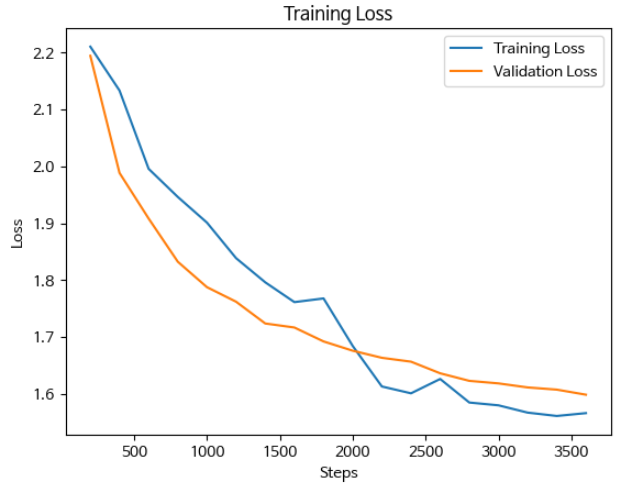

대체로 학습이 안정적으로 진행되는 모습을 보였다.

특히 validation loss가 안정적으로 떨어졌기 때문에 일반화 성능도 높을 것이라고 생각된다.

## 4. 학습시 시행착오에 대한 고찰

- LLM모델을 Fine-tuning하는 작업은 처음이었기 때문에 모델 자체에 대한 이해도가 낮아 구현에 어려움이 있었다. 특히 huggingface내에 있는 Encoder-only모델과 Decoder-only모델의 구조와 토크나이징 방식의 차이 때문에, 어려움이 있었다.

- 또한 Encoder-only모델에 더 최적화된 SQuAD데이터셋을 Decoder-only모델로 해결하려고 하다 보니까 두 모델의 방식차이 때문에 혼동이 와 어려움이 있었다.

- 개발 환경이 불안정해 모델을 돌릴 때 이전에 돌렸던 모델의 매개변수가 GPU memory에 남아있어 이를 해결하거나, 학습 도중 서버가 닫혀 모델을 다시 돌리는 등의 어려움이 있었다.

- 3번의 학습동안 출력값이 []로 나오는 문제가 발생한 적이 있었는데, prepare_model_for_kbit_training과 get_peft_model의 위치가 바뀌어 모든 학습가능한 파라미터가 0이어서 학습이 진행이 안되었다는 것을 깨달았다. 이후 위치를 바꾸어 정상적으로 학습이 진행되었다.